## 词袋模型

使用id映射的起因是因为 ，机器学习算法的输入都是数值，所以我们要把文本转化为数字送入网络。此时对应的数字仅代表分类，而不具有数值关系。
同时，算法模型期望相同长度的语句，因此要将句子转化为一个稀疏向量。
最开始的规则是：如果对应索引上的单词存在，则对应的索引位置的值为1。此方法的缺点是损失了句子中单词的顺序特征（也就是这个词出现了，则对应位置就为1，而与这个词出现在句子的哪个位置无关了）
为解决上述问题，引入“词袋”嵌入。

例子：使用“词袋”嵌入进行垃圾短信的预测。

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import csv
import string
from tensorflow.contrib import learn
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [30]:
file_path = 'D:\datasets\smsspamcollection\SMSSpamCollection'

df = pd.read_csv(file_path, delimiter='\t', header=None)# 用\t分割，没有文件头

# 生成文本和标签
target, texts = df[0], df[1]
target = [1.0 if x=='spam' else 0.0 for x in target]
target[:10],type(target[0])

([0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0], float)

2.对文本进行规则化处理，移除文本中大小写和数字的影响

In [3]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [4]:
texts = [x.lower() for x in texts]
# 去除标点
texts = [''.join(c for c in x if c not in string.punctuation)for x in texts]
# 去除数字
texts = [''.join(c for c in x if c not in '1234567890')for x in texts]
texts[:5]

['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat',
 'ok lar joking wif u oni',
 'free entry in  a wkly comp to win fa cup final tkts st may  text fa to  to receive entry questionstd txt ratetcs apply overs',
 'u dun say so early hor u c already then say',
 'nah i dont think he goes to usf he lives around here though']

In [5]:
# 去除多余空白？
texts = [' '.join(x.split())for x in texts]
texts[:5]

['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat',
 'ok lar joking wif u oni',
 'free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry questionstd txt ratetcs apply overs',
 'u dun say so early hor u c already then say',
 'nah i dont think he goes to usf he lives around here though']

3.计算最长句子的大小

Text(0.5, 1.0, 'histogram of words in texts')

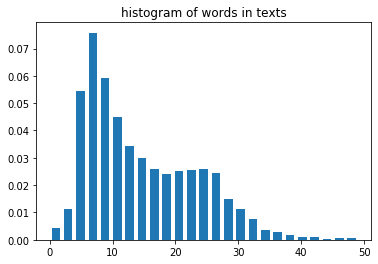

In [6]:
# 计算句子含有多少个单词，而不是句子字符串的长度
text_lengths = [len(x.split()) for x in texts]
text_lengths = [x for x in text_lengths if x <50]
#bins是直方图柱子的个数，个数越多，划分的越细，柱子越多，那么数量每个柱子的数量可能就小了,normed=1是频率图，不加是频数图
plt.hist(text_lengths,bins=25,normed=1,rwidth=0.7) 
plt.title('histogram of words in texts')

In [7]:
for x in texts[:1]:
    print(x)
    print(x.split())
    print(len(x))
    print(len(x.split()))

go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
102
20


使用tensorflow分词

In [8]:
sentence_size = 25
min_word_freq = 3

vocab_processor = learn.preprocessing.VocabularyProcessor(sentence_size,min_frequency= min_word_freq)
vocab_processor.fit_transform(texts)
embedding_size = len(vocab_processor.vocabulary_)
embedding_size

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


2110

分割训练集和测试集

In [9]:
train_indices = np.random.choice(len(texts),round(len(texts)*0.8),replace=False)
train_indices[:10]

array([2252,  721, 2540, 3414, 1802, 4867, 1077, 4097, 5240, 1097])

In [10]:
test_indices = np.array(list(set(range(len(texts)))-set(train_indices)))
test_indices[:10]

array([   4, 4106,   11,   13, 2062,   15, 2064, 4110, 4115, 4117])

In [11]:
texts_train = [x for idx,x in enumerate(texts) if idx in train_indices]
texts_test = [x for idx,x in enumerate(texts) if idx in test_indices]
target_train = [x for idx,x in enumerate(target) if idx in train_indices]
target_test = [x for idx,x in enumerate(target) if idx in test_indices]
len(texts_train),len(texts_test),len(target_train),len(target_test)

(4458, 1114, 4458, 1114)

转化为词向量需要：
1. 将句子单词转成索引
2. 将索引转成one-hot向量，该向量为单位矩阵-->索引的时候可能有1、2、3，转换成one-hot就仅有0和1，索引数值所在位置为1，其余为0，所以每个单词是一行向量（embedding_size)，而每句话会是一个矩阵,有sentence_size行。
3. 使用该矩阵为每个单词查找稀疏向量，并加入词稀疏向量

首先，声明词嵌入矩阵

In [12]:
ones_mat = tf.ones(shape=[embedding_size])
identity_mat = tf.diag(ones_mat)
ones_mat,identity_mat

(<tf.Tensor 'ones:0' shape=(2110,) dtype=float32>,
 <tf.Tensor 'Diag:0' shape=(2110, 2110) dtype=float32>)

In [13]:
with tf.Session() as sess:
    print(sess.run(identity_mat))

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


初始化占位符，并使用tf的嵌入查找函数来隐射句子中的单词为单位矩阵的one-hot向量

In [14]:
# x_data 被用来查找单位矩阵的索引，tf要求其为整数类型
x_data = tf.placeholder(shape = [sentence_size],dtype=tf.int32)
y_target = tf.placeholder(shape=[1,1],dtype=tf.float32)
x_data,y_target

(<tf.Tensor 'Placeholder:0' shape=(25,) dtype=int32>,
 <tf.Tensor 'Placeholder_1:0' shape=(1, 1) dtype=float32>)

In [15]:
x_embed = tf.nn.embedding_lookup(identity_mat,x_data)
x_embed

<tf.Tensor 'embedding_lookup/Identity:0' shape=(25, 2110) dtype=float32>

为什么要把前面的向量求和？？--> 

In [16]:
x_col_sums = tf.reduce_sum(x_embed,0)
x_col_sums

<tf.Tensor 'Sum:0' shape=(2110,) dtype=float32>

进行逻辑回归，首先声明变量和模型

In [27]:
W = tf.Variable(tf.random_normal(shape = [embedding_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))
W,b

(<tf.Variable 'Variable_2:0' shape=(2110, 1) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(1, 1) dtype=float32_ref>)

In [28]:
x_col_sums_2D = tf.expand_dims(x_col_sums,0)
model_output = tf.add(tf.matmul(x_col_sums_2D,W),b)
x_col_sums_2D,model_output

(<tf.Tensor 'ExpandDims_1:0' shape=(1, 2110) dtype=float32>,
 <tf.Tensor 'Add_1:0' shape=(1, 1) dtype=float32>)

声明训练模型的损失函数、预测函数和优化器

In [19]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output,labels=y_target))
prediction = tf.sigmoid(model_output)
opt = tf.train.GradientDescentOptimizer(0.001)
train_step = opt.minimize(loss)

初始化计算图中的变量

In [20]:
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


开始迭代训练 没有写epoch为什么就训练4400代就自己停止了？？ -->不是4400代！是一代！然后4400+个单词，每个单词训练一次

In [26]:
loss_vec,train_acc_all,train_acc_avg = [],[],[]
for i in range(10):
    for idx,t in enumerate(vocab_processor.fit_transform(texts_train)):
        sess.run(train_step,feed_dict = {x_data:t,y_target:y})
        temp_loss = sess.run(loss,feed_dict={x_data:t,y_target:y})
        loss_vec.append(temp_loss)
        # 预测结果
        [[temp_pred]]=sess.run(prediction,feed_dict={x_data:t,y_target:y})
        #判断预测结果是否正确
        train_acc_temp = target_train[idx]==np.round(temp_pred)
        train_acc_all.append(train_acc_temp)
    train_acc_avg = np.mean(train_acc_all)
    print("training epoch # %s : acc = %s"%(str(i),train_acc_avg))

training epoch # 0 : acc = 0.8530731269627636
training epoch # 1 : acc = 0.8534096007178107
training epoch # 2 : acc = 0.8538956183639899
training epoch # 3 : acc = 0.8545872588604756
training epoch # 4 : acc = 0.8551368326603859
training epoch # 5 : acc = 0.8556901450575743
training epoch # 6 : acc = 0.8561815035570083
training epoch # 7 : acc = 0.8565500224315836
training epoch # 8 : acc = 0.8569363441503415
training epoch # 9 : acc = 0.857335127860027


一个非常简单、基础的词袋模型，不考虑单词的位置、权重等信息，单纯靠句子中出现过哪些单词（词袋中的单词）来进行映射，并进行one-hot稀疏编码。
通过embedding_lookup对应一个句子（长度25）的编码矩阵（25*2110），通过行相加，得到句子的编码（2110）
通过句子编码(2110,1)*W(1,2110)+b(1,1)= (1,1)训练W和b。
没有经过网络层光通过embedding层竟然能达到85%的准确率。参考资料说是因为长度25的限定，限定的好？